# Capstone - Battle of the Neighbourhoods

In [146]:
#Import Packages
from bs4 import BeautifulSoup
import requests

import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import datetime
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 
import requests 
from pandas.io.json import json_normalize 

from geopy.geocoders import Nominatim 
import geopy
import geopandas

import folium # map rendering library

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans



## Report Sections


For the second week, the final deliverables of the project will be:

- A link to your Notebook on your Github repository, showing your code. (15 marks)

<I> A full report consisting of all of the following components (15 marks): </I>

- Introduction where you discuss the business problem and who would be interested in this project.
- Data where you describe the data that will be used to solve the problem and the source of the data.
- Methodology section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.
- Results section where you discuss the results.
- Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.
- Conclusion section where you conclude the report.

<hr>
<hr>
<hr>

In [147]:
# Function to get categories from venues
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [148]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [208]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [213]:
#Put into pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [149]:
address = 'Dublin,Ireland'

geolocator = geopy.Nominatim(user_agent="google", timeout=30)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {}: {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Dublin,Ireland: 53.3497645, -6.2602732.


Foursquare API to identify neighbouring venues

In [150]:
CLIENT_ID = "OHPWNGYBB0FL3RDXDPXM4FQAGYL2HJQESEPA55EAACARKOUN" # your Foursquare ID
CLIENT_SECRET = "ZYZFOGXO3TH4SJHKUIALEKCX0K1THXXSKUCBVI414GGP3MXR" # your Foursquare Secret
VERSION = "20180604"
LIMIT = 300
radius = 5000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
    
url

'https://api.foursquare.com/v2/venues/explore?&client_id=OHPWNGYBB0FL3RDXDPXM4FQAGYL2HJQESEPA55EAACARKOUN&client_secret=ZYZFOGXO3TH4SJHKUIALEKCX0K1THXXSKUCBVI414GGP3MXR&v=20180604&ll=53.3497645,-6.2602732&radius=5000&limit=300'

### Cities on the Ireland Island

In [151]:
#Extract data from wikipedia
website_url = requests.get("https://en.wikipedia.org/wiki/List_of_settlements_on_the_island_of_Ireland_by_population").text
soup = BeautifulSoup(website_url,"lxml")
My_table = soup.find("table",{"class":"wikitable sortable"})
table_data = My_table.tbody.find_all("tr")
column = [x.text.strip() for x in table_data[0].find_all("th")]
column

['Rank',
 'Settlement',
 'Population',
 'Province',
 'County',
 'Jurisdiction',
 'Description']

In [152]:
# View what table encoding looks like
table_data[1]

<tr>
<td>1
</td>
<td><a href="/wiki/Dublin" title="Dublin">Dublin</a>
</td>
<td>1,173,179
</td>
<td><a href="/wiki/Leinster" title="Leinster">Leinster</a>
</td>
<td><span class="nowrap"><a href="/wiki/County_Dublin" title="County Dublin">County Dublin</a></span>
</td>
<td><a href="/wiki/Republic_of_Ireland" title="Republic of Ireland">Republic</a>
</td>
<td>Capital city of the Republic of Ireland and has mainly been the island's largest settlement since the <a href="/wiki/Middle_Ages" title="Middle Ages">Middle Ages</a> (<a href="/wiki/Belfast" title="Belfast">Belfast</a> had a larger population than Dublin for a while in the very late nineteenth-century and very early twentieth-century).
</td></tr>

In [153]:
data_table = pd.DataFrame(columns = column)

#Create basic data table - Top 60 cities
rows = []
for i in range(1,61):
    try:
        rows = [x.text.strip() for x in table_data[i].find_all("td")]
        data_table.loc[i] = rows
    except:
        next
    next

data_table

,Rank,Settlement,Population,Province,County,Jurisdiction,Description
1,1,Dublin,"1,173,179",Leinster,County Dublin,Republic,Capital city of the Republic of Ireland and ha...
2,2,Belfast,"483,418",Ulster,"County Antrim, County Down",Northern,Capital of Northern Ireland and largest city i...
3,3,Cork,"208,669",Munster,County Cork,Republic,Largest city in the province of Munster in the...
4,4,Limerick,"94,192",Munster,"County Limerick, County Clare",Republic,Principal city of Ireland's Mid-West Region an...
5,5,Derry,"93,512",Ulster,County Londonderry,Northern,Second-largest city in all of Ulster
6,6,Galway,"79,934",Connacht,County Galway,Republic,Largest city in the province of Connacht and t...
7,7,Newtownabbey,"65,646",Ulster,County Antrim,Northern,Largest town in Northern Ireland and Ireland a...
8,8,Bangor,"61,011",Ulster,County Down,Northern,The town is part of the Belfast Metropolitan Area
9,9,Waterford,"53,504",Munster,"County Waterford, County Kilkenny",Republic,Third-largest in the province of Munster. It i...
10,10,Lisburn,"45,370",Ulster,"County Antrim, County Down",Northern,Granted city status in 2002. The city lies on ...


In [154]:
data_table.dtypes

Rank            object
Settlement      object
Population      object
Province        object
County          object
Jurisdiction    object
Description     object
dtype: object

In [156]:
data_table["Latitude"] = np.nan
data_table["Longitude"] = np.nan
data_table["Settlement"] = data_table["Settlement"].str.strip("[3]")
data_table["Population"] = data_table["Population"].str.replace(',','')
data_table["Population"] = data_table["Population"].str.strip('[3]')
data_table["Population"] = data_table["Population"].str.strip('[4]')
data_table["Population"] = pd.to_numeric(data_table["Population"])

In [233]:
data_table["Rank"] = pd.to_numeric(data_table["Rank"])

In [158]:
data_table.dtypes

Rank             object
Settlement       object
Population        int64
Province         object
County           object
Jurisdiction     object
Description      object
Latitude        float64
Longitude       float64
dtype: object

In [159]:
# Use the geopy package to add the coordinates to the data table
for i in range(1,len(data_table)):
    try:
        address = data_table.loc[i,"Settlement"] + ", " + data_table.loc[i,"Province"] 
        geolocator = geopy.Nominatim(user_agent="google", timeout=30)
        location = geolocator.geocode(address)
        data_table.loc[i,"Latitude"] = location.latitude
        data_table.loc[i,"Longitude"] = location.longitude
    except:
        next
    next
    
data_table.head()

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude
1,1,Dublin,1173179,Leinster,County Dublin,Republic,Capital city of the Republic of Ireland and ha...,53.349764,-6.260273
2,2,Belfast,83418,Ulster,"County Antrim, County Down",Northern,Capital of Northern Ireland and largest city i...,54.586933,-5.900324
3,3,Cork,208669,Munster,County Cork,Republic,Largest city in the province of Munster in the...,51.897928,-8.470581
4,4,Limerick,94192,Munster,"County Limerick, County Clare",Republic,Principal city of Ireland's Mid-West Region an...,52.661252,-8.630124
5,5,Derry,93512,Ulster,County Londonderry,Northern,Second-largest city in all of Ulster,55.005915,-7.323124


In [160]:
# Checking where all the coordinates are missing to be filled in manually
data_table[data_table["Latitude"].isnull()]

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude
16,16,Ballymena,29551,Ulster,County Antrim,Northern,,NaN,NaN
38,38,Larne,18755,Ulster,County Antrim,Northern,,NaN,NaN
49,49,Dungannon,14340,Ulster,County Tyrone,Northern,,NaN,NaN
58,58,Limavady,12032,Ulster,County Londonderry,Northern,,NaN,NaN
59,59,Laytown-Bettystown-Mornington,11872,Leinster,County Meath,Republic,,NaN,NaN
60,60,Cookstown,11599,Ulster,County Tyrone,Northern,,NaN,NaN


In [161]:
#data_table[data_table["Latitude"].isnull()]
data_table["Latitude"][data_table["Settlement"] == "Ballymena"] = 54.8653
data_table["Longitude"][data_table["Settlement"] == "Ballymena"] = -6.2802
data_table["Latitude"][data_table["Settlement"] == "Larne"] = 54.8578
data_table["Longitude"][data_table["Settlement"] == "Larne"] = -5.8236
data_table["Latitude"][data_table["Settlement"] == "Dungannon"] = 54.5083
data_table["Longitude"][data_table["Settlement"] == "Dungannon"] = -6.7669
data_table["Latitude"][data_table["Settlement"] == "Limavady"] = 55.0455
data_table["Longitude"][data_table["Settlement"] == "Limavady"] = -6.9337
data_table["Latitude"][data_table["Settlement"] == "Laytown-Bettystown-Mornington"] = 53.6925
data_table["Longitude"][data_table["Settlement"] == "Laytown-Bettystown-Mornington"] = -6.2402
data_table["Latitude"][data_table["Settlement"] == "Cookstown"] = 54.6418
data_table["Longitude"][data_table["Settlement"] == "Cookstown"] = -6.7444

In [162]:
data_table["County"] = data_table["County"].str.replace("County ","")

data_table

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude
1,1,Dublin,1173179,Leinster,Dublin,Republic,Capital city of the Republic of Ireland and ha...,53.349764,-6.260273
2,2,Belfast,83418,Ulster,"Antrim, Down",Northern,Capital of Northern Ireland and largest city i...,54.586933,-5.900324
3,3,Cork,208669,Munster,Cork,Republic,Largest city in the province of Munster in the...,51.897928,-8.470581
4,4,Limerick,94192,Munster,"Limerick, Clare",Republic,Principal city of Ireland's Mid-West Region an...,52.661252,-8.630124
5,5,Derry,93512,Ulster,Londonderry,Northern,Second-largest city in all of Ulster,55.005915,-7.323124
6,6,Galway,7993,Connacht,Galway,Republic,Largest city in the province of Connacht and t...,53.274412,-9.049063
7,7,Newtownabbey,65646,Ulster,Antrim,Northern,Largest town in Northern Ireland and Ireland a...,54.686821,-5.896525
8,8,Bangor,61011,Ulster,Down,Northern,The town is part of the Belfast Metropolitan Area,54.654138,-5.801582
9,9,Waterford,5350,Munster,"Waterford, Kilkenny",Republic,Third-largest in the province of Munster. It i...,52.261000,-7.111908
10,10,Lisburn,5370,Ulster,"Antrim, Down",Northern,Granted city status in 2002. The city lies on ...,54.549021,-6.006967


In [167]:
#Visualise on Map
# create map of Manhattan using latitude and longitude values
map_ireland = folium.Map(location=[latitude, longitude], zoom_start=7)

# add markers to map
for lat, lng, label in zip(data_table['Latitude'], data_table['Longitude'], data_table['Settlement']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='#202e39',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_ireland)  
    
map_ireland

## Exploratory Data Analysis

In [168]:
data_table

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude
1,1,Dublin,1173179,Leinster,Dublin,Republic,Capital city of the Republic of Ireland and ha...,53.349764,-6.260273
2,2,Belfast,83418,Ulster,"Antrim, Down",Northern,Capital of Northern Ireland and largest city i...,54.586933,-5.900324
3,3,Cork,208669,Munster,Cork,Republic,Largest city in the province of Munster in the...,51.897928,-8.470581
4,4,Limerick,94192,Munster,"Limerick, Clare",Republic,Principal city of Ireland's Mid-West Region an...,52.661252,-8.630124
5,5,Derry,93512,Ulster,Londonderry,Northern,Second-largest city in all of Ulster,55.005915,-7.323124
6,6,Galway,7993,Connacht,Galway,Republic,Largest city in the province of Connacht and t...,53.274412,-9.049063
7,7,Newtownabbey,65646,Ulster,Antrim,Northern,Largest town in Northern Ireland and Ireland a...,54.686821,-5.896525
8,8,Bangor,61011,Ulster,Down,Northern,The town is part of the Belfast Metropolitan Area,54.654138,-5.801582
9,9,Waterford,5350,Munster,"Waterford, Kilkenny",Republic,Third-largest in the province of Munster. It i...,52.261000,-7.111908
10,10,Lisburn,5370,Ulster,"Antrim, Down",Northern,Granted city status in 2002. The city lies on ...,54.549021,-6.006967


In [173]:
data_table.pivot_table(index = "Province", columns = "Jurisdiction", values = "County",aggfunc = "count",fill_value = 0)

Jurisdiction,Northern,Republic
Province,,
Connacht,0,3
Leinster,0,24
Munster,0,11
Ulster,20,1


In [180]:
data_table.pivot_table(index = "Province", columns = ["Jurisdiction","County"], values = "Rank",aggfunc = "count",fill_value = 0)

Jurisdiction Northern                                             Republic  \
County         Antrim Antrim, Down Armagh Down Londonderry Tyrone   Carlow   
Province                                                                     
Connacht            0            0      0    0           0      0        0   
Leinster            0            0      0    0           0      0        1   
Munster             0            0      0    0           0      0        0   
Ulster              5            2      2    4           3      4        0   

Jurisdiction                                                                \
County       Clare Cork Donegal Dublin Galway Kerry Kildare Kilkenny Laois   
Province                                                                     
Connacht         0    0       0      0      1     0       0        0     0   
Leinster         0    0       0      4      0     0       5        1     1   
Munster          1    5       0      0      0     2       0        0     0   
Ulster           0    0       1      0      0     0       0        0     0   

Jurisdiction                                                             \
County       Limerick, Clare Louth Louth, Meath Mayo Meath Offaly Sligo   
Province                                                                  
Connacht                   0     0            0    1     0      0     1   
Leinster                   0     1            1    0     3      1     0   
Munster                    1     0            0    0     0      0     0   
Ulster                     0     0            0    0     0      0     0   

Jurisdiction                                                           
County       Tipperary Waterford,  Kilkenny Westmeath Wexford Wicklow  
Province                                                               
Connacht             0                    0         0       0       0  
Leinster             0                    0         2       1       3  
Munster              1                    1         0       0       0  
Ulster               0                    0         0       0       0

In [182]:
data_table.pivot_table(index = "Province", values = "Population",aggfunc = "sum",fill_value = 0)

,Population
Province,
Connacht,39260
Leinster,1480479
Munster,429293
Ulster,592359


In [195]:
data_table.describe(include = "all")

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude
count,59,59,5.900000e+01,59,59,59,59,59.000000,59.000000
unique,58,59,NaN,4,28,2,30,NaN,NaN
top,19,Naas,NaN,Leinster,Antrim,Republic,,NaN,NaN
freq,2,1,NaN,24,5,39,30,NaN,NaN
mean,NaN,NaN,4.307442e+04,NaN,NaN,NaN,NaN,53.604616,-7.051436
std,NaN,NaN,1.530104e+05,NaN,NaN,NaN,NaN,0.965216,1.052872
min,NaN,NaN,1.700000e+01,NaN,NaN,NaN,NaN,51.825855,-9.705409
25%,NaN,NaN,1.173550e+04,NaN,NaN,NaN,NaN,52.940200,-7.598364
50%,NaN,NaN,1.663700e+04,NaN,NaN,NaN,NaN,53.511615,-6.683362
75%,NaN,NaN,2.353300e+04,NaN,NaN,NaN,NaN,54.565653,-6.250237


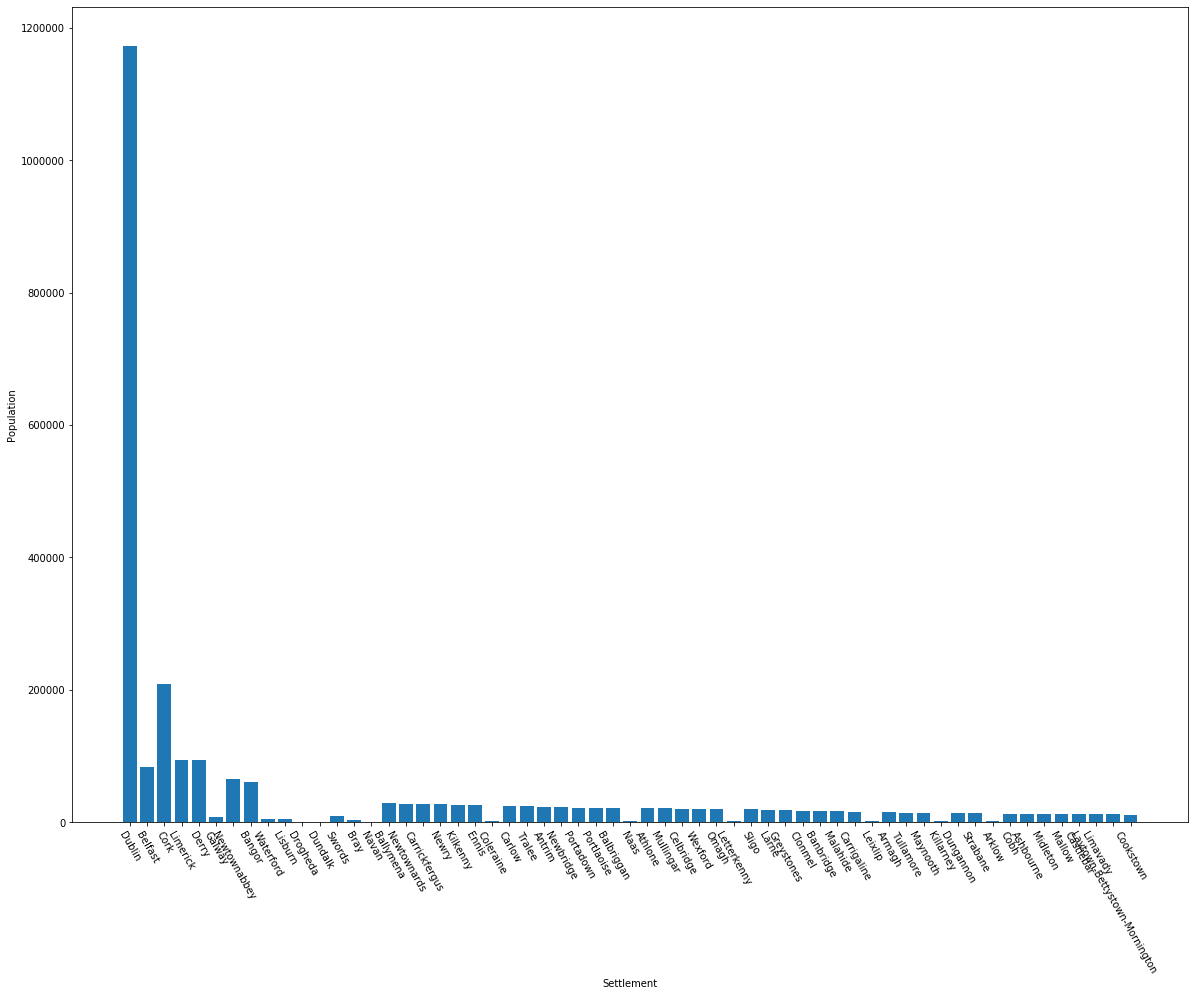

In [197]:
plt.figure(figsize = (20,15))
plt.bar(data_table["Settlement"], data_table["Population"])
plt.xlabel("Settlement")
plt.ylabel("Population")
plt.xticks(rotation = -60)
plt.show()

In [203]:
data_table["Description"][3]

"Largest city in the province of Munster in the south of Ireland. Cork is one of Ireland's oldest cities, having received city status in the 900s."

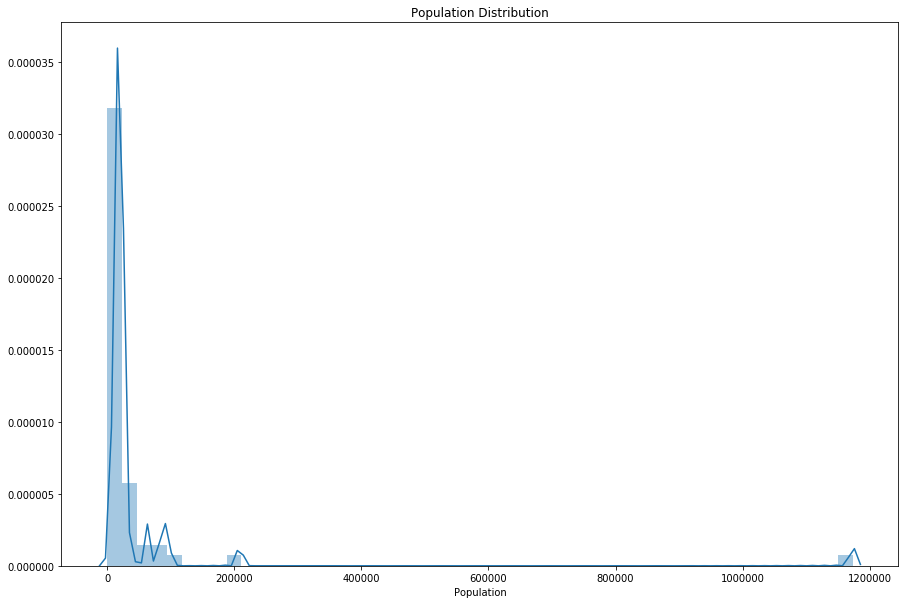

In [193]:
plt.figure(figsize = (15,10))
sns.distplot(data_table["Population"])
plt.title("Population Distribution")
plt.show()

### Clustering and using of Foursquare API 

In [204]:
CLIENT_ID = 'OHPWNGYBB0FL3RDXDPXM4FQAGYL2HJQESEPA55EAACARKOUN' # your Foursquare ID
CLIENT_SECRET = 'ZYZFOGXO3TH4SJHKUIALEKCX0K1THXXSKUCBVI414GGP3MXR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: OHPWNGYBB0FL3RDXDPXM4FQAGYL2HJQESEPA55EAACARKOUN
CLIENT_SECRET:ZYZFOGXO3TH4SJHKUIALEKCX0K1THXXSKUCBVI414GGP3MXR


In [205]:
address = 'Belfast, Ulster'

geolocator = geopy.Nominatim(user_agent="google", timeout=30)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {}: {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of Belfast, Ulster: 54.5869333, -5.9003239.


In [206]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=OHPWNGYBB0FL3RDXDPXM4FQAGYL2HJQESEPA55EAACARKOUN&client_secret=ZYZFOGXO3TH4SJHKUIALEKCX0K1THXXSKUCBVI414GGP3MXR&v=20180605&ll=54.5869333,-5.9003239&radius=500&limit=100'

In [207]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e68b99347b43d002331111d'},
 'response': {'headerLocation': 'Woodstock',
  'headerFullLocation': 'Woodstock, Belfast',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 7,
  'suggestedBounds': {'ne': {'lat': 54.5914333045, 'lng': -5.892572635359874},
   'sw': {'lat': 54.582433295499996, 'lng': -5.908075164640126}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4d7245695f0037040a17dda0',
       'name': 'Co-op Food',
       'location': {'address': '61 Cregagh Road,',
        'lat': 54.58446453365169,
        'lng': -5.899122016156487,
        'labeledLatLngs': [{'label': 'display',
          'lat': 54.58446453365169,
          'lng': -5.899122016156487}],
        'distance': 285,
        'postalCode': 'BT6 8PY',
       

In [209]:
# Venues in Belfast

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Co-op Food,Grocery Store,54.584465,-5.899122
1,Tesco,Supermarket,54.588489,-5.893876
2,Tesco Express,Grocery Store,54.583472,-5.898525
3,Wyse Byse,Department Store,54.586314,-5.898871
4,Orrs Bakery,Bakery,54.588004,-5.900101


In [210]:
# Get nearby venues by the settlements on Ireland
ireland_venues = getNearbyVenues(names=data_table['Settlement'],
                                   latitudes=data_table['Latitude'],
                                   longitudes=data_table['Longitude']
                                  )

Dublin
Belfast
Cork
Limerick
Derry
Galway
Newtownabbey
Bangor
Waterford
Lisburn
Drogheda
Dundalk
Swords
Bray
Navan
Ballymena
Newtownards
Carrickfergus
Newry
Kilkenny
Ennis
Coleraine
Carlow
Tralee
Antrim
Newbridge
Portadown
Portlaoise
Balbriggan
Naas
Athlone
Mullingar
Celbridge
Wexford
Omagh
Letterkenny
Sligo
Larne
Greystones
Clonmel
Banbridge
Malahide
Carrigaline
Leixlip
Armagh
Tullamore
Maynooth
Killarney
Dungannon
Strabane
Arklow
Cobh
Ashbourne
Midleton
Mallow
Castlebar
Limavady
Laytown-Bettystown-Mornington
Cookstown


In [211]:
#Analyse Cities

# one hot encoding
ireland_onehot = pd.get_dummies(ireland_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
ireland_onehot['Neighborhood'] = ireland_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [ireland_onehot.columns[-1]] + list(ireland_onehot.columns[:-1])
ireland_onehot = ireland_onehot[fixed_columns]

ireland_onehot.head()

,Neighborhood,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Bagel Shop,Bakery,Bar,Beach,Bed & Breakfast,Bistro,Bookstore,Botanical Garden,Breakfast Spot,Brewery,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Café,Castle,Cheese Shop,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Donut Shop,Electronics Store,Entertainment Service,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food,Food & Drink Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health Food Store,History Museum,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Jewelry Store,Korean Restaurant,Lawyer,Liquor Store,Lounge,Malay Restaurant,Market,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Opera House,Optical Shop,Outdoor Sculpture,Park,Pastry Shop,Performing Arts Venue,Pharmacy,Pie Shop,Pizza Place,Platform,Playground,Plaza,Port,Post Office,Pub,Restaurant,River,Road,Rock Club,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Snack Place,Souvenir Shop,Spa,Spanish Restaurant,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Toy / Game Store,Train Station,Vacation Rental,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar
0,Dublin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Dublin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Dublin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Dublin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Dublin,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [212]:
# Top 5 venues by the cities

ireland_grouped = ireland_onehot.groupby('Neighborhood').mean().reset_index()

num_top_venues = 5

for hood in ireland_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = ireland_grouped[ireland_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Antrim----
         venue  freq
0  Coffee Shop  0.11
1         Café  0.11
2        Hotel  0.09
3   Restaurant  0.06
4          Bar  0.06


----Arklow----
              venue  freq
0         Nightclub  0.17
1       Coffee Shop  0.17
2  Department Store  0.17
3        Restaurant  0.17
4         Multiplex  0.17


----Ashbourne----
                  venue  freq
0           Supermarket  0.16
1    Italian Restaurant  0.12
2  Fast Food Restaurant  0.08
3                Bistro  0.04
4           Pizza Place  0.04


----Athlone----
                venue  freq
0         Coffee Shop  0.17
1                 Pub  0.12
2          Restaurant  0.12
3  Italian Restaurant  0.08
4               Hotel  0.08


----Balbriggan----
             venue  freq
0        Multiplex  0.11
1            Hotel  0.11
2      Supermarket  0.11
3  Harbor / Marina  0.11
4       Food Court  0.11


----Ballymena----
                  venue  freq
0           Coffee Shop  0.16
1        Clothing Store  0.12
2  Fast Food Restau

                  venue  freq
0           Supermarket  0.17
1            Restaurant  0.17
2             Nightclub  0.17
3  Fast Food Restaurant  0.17
4         Train Station  0.17


----Portlaoise----
                venue  freq
0                Café  0.17
1               Hotel  0.17
2      Clothing Store  0.08
3  Italian Restaurant  0.08
4   Indian Restaurant  0.08


----Sligo----
          venue  freq
0           Pub  0.17
1          Café  0.09
2     Gastropub  0.09
3  Gourmet Shop  0.06
4         Hotel  0.06


----Strabane----
                  venue  freq
0           Bus Station  0.25
1        Sandwich Place  0.25
2  Fast Food Restaurant  0.25
3           Coffee Shop  0.25
4           Pastry Shop  0.00


----Swords----
           venue  freq
0            Pub  0.25
1            Bar  0.15
2    Pizza Place  0.05
3  Garden Center  0.05
4     Steakhouse  0.05


----Tralee----
                  venue  freq
0                   Pub  0.19
1           Coffee Shop  0.11
2    Italian Restauran

In [217]:
# Find top 10 Most common Venues by the Settlement

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = ireland_grouped['Neighborhood']

for ind in np.arange(ireland_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(ireland_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Antrim,Coffee Shop,Café,Hotel,Hostel,Restaurant,Bar,Fast Food Restaurant,Pub,Convenience Store,Park
1,Arklow,Multiplex,Shopping Mall,Restaurant,Nightclub,Coffee Shop,Department Store,Fish & Chips Shop,Food Court,Food & Drink Shop,Food
2,Ashbourne,Supermarket,Italian Restaurant,Fast Food Restaurant,Bistro,Pizza Place,Hotel,Pub,Coffee Shop,Sandwich Place,Shopping Mall
3,Athlone,Coffee Shop,Pub,Restaurant,Italian Restaurant,Bar,Hotel,Shopping Mall,Bistro,Café,River
4,Balbriggan,Hotel,Food Court,Pizza Place,Train Station,Harbor / Marina,Supermarket,Multiplex,Bar,Beach,Wine Bar


In [218]:
#Cluster the settlements

from sklearn.cluster import KMeans
ireland_grouped_clustering = ireland_grouped.drop('Neighborhood', 1)
sse = {}
# set number of clusters
for i in range(2,21):
    #kclusters = 5
    # run k-means clustering
    kmeans = KMeans(n_clusters = i, random_state=0).fit(ireland_grouped_clustering)
    ireland_grouped_clustering['Cluster'] = kmeans.labels_
    sse[i] = kmeans.inertia_

# check cluster labels generated for each row in the dataframe

sse

{2: 8.145198446899883,
 3: 7.132410505984052,
 4: 6.226294300265993,
 5: 5.227125486241527,
 6: 4.708959118011628,
 7: 4.377209603367277,
 8: 4.085228980748236,
 9: 3.8509899710688966,
 10: 3.5980146360660625,
 11: 3.3221542800177954,
 12: 3.0565481377860824,
 13: 2.796704468370383,
 14: 2.609204468370383,
 15: 2.421704468370383,
 16: 2.2626872494380197,
 17: 2.1158453255949845,
 18: 1.953829470747853,
 19: 1.827041740173087,
 20: 1.6750898325606618}

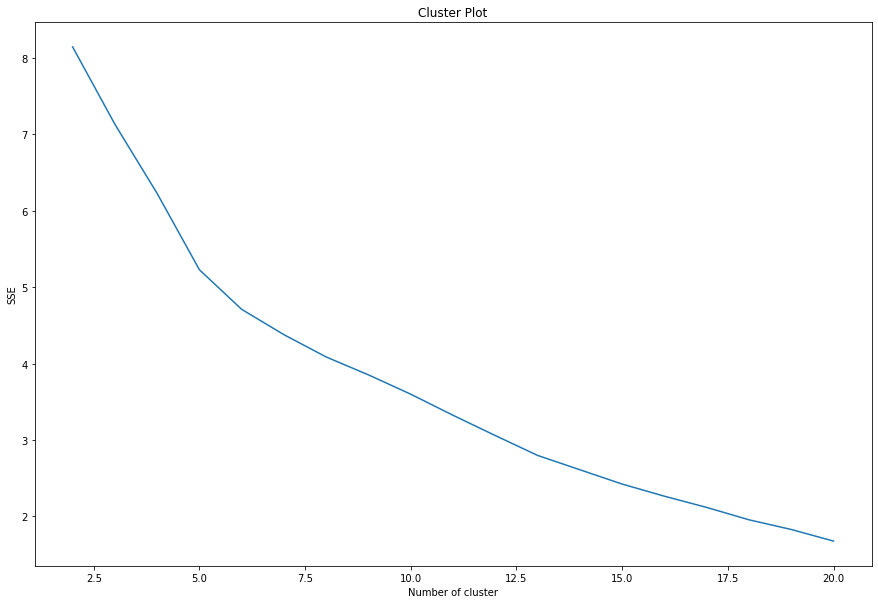

In [219]:
plt.figure(figsize = (15,10))
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.title("Cluster Plot")
plt.show()

In [220]:
#Try 5 clusters

kclusters = 5
    # run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(ireland_grouped_clustering)
ireland_grouped_clustering['Cluster Labels'] = kmeans.labels_
neighborhoods_venues_sorted['Cluster Labels'] = kmeans.labels_
kmeans.labels_[0:10] 


array([0, 2, 4, 0, 4, 2, 4, 1, 3, 4])

In [221]:
neighborhoods_venues_sorted.rename(columns = {"Neighborhood":"Settlement"}, inplace = True)

In [222]:
neighborhoods_venues_sorted

,Settlement,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,Antrim,Coffee Shop,Café,Hotel,Hostel,Restaurant,Bar,Fast Food Restaurant,Pub,Convenience Store,Park,0
1,Arklow,Multiplex,Shopping Mall,Restaurant,Nightclub,Coffee Shop,Department Store,Fish & Chips Shop,Food Court,Food & Drink Shop,Food,2
2,Ashbourne,Supermarket,Italian Restaurant,Fast Food Restaurant,Bistro,Pizza Place,Hotel,Pub,Coffee Shop,Sandwich Place,Shopping Mall,4
3,Athlone,Coffee Shop,Pub,Restaurant,Italian Restaurant,Bar,Hotel,Shopping Mall,Bistro,Café,River,0
4,Balbriggan,Hotel,Food Court,Pizza Place,Train Station,Harbor / Marina,Supermarket,Multiplex,Bar,Beach,Wine Bar,4
5,Ballymena,Coffee Shop,Clothing Store,Fast Food Restaurant,Train Station,Pub,Platform,Bus Station,Gastropub,Medical Supply Store,Mobile Phone Shop,2
6,Banbridge,Pizza Place,Supermarket,Bakery,Coffee Shop,Fried Chicken Joint,Multiplex,Gas Station,Hotel Bar,Asian Restaurant,Harbor / Marina,4
7,Bangor,Hotel,Train Station,Bed & Breakfast,Spa,Wine Bar,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop,1
8,Belfast,Grocery Store,Bakery,Department Store,Pastry Shop,Supermarket,Seafood Restaurant,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,3
9,Bray,Café,Pub,Supermarket,Hotel,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Breakfast Spot,Gym / Fitness Center,Theater,4


In [223]:
final_table = pd.merge(data_table,neighborhoods_venues_sorted, on='Settlement')
final_table.head()

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,Dublin,1173179,Leinster,Dublin,Republic,Capital city of the Republic of Ireland and ha...,53.349764,-6.260273,Pub,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Burrito Place,Bookstore,Japanese Restaurant,Food & Drink Shop,0
1,2,Belfast,83418,Ulster,"Antrim, Down",Northern,Capital of Northern Ireland and largest city i...,54.586933,-5.900324,Grocery Store,Bakery,Department Store,Pastry Shop,Supermarket,Seafood Restaurant,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,3
2,3,Cork,208669,Munster,Cork,Republic,Largest city in the province of Munster in the...,51.897928,-8.470581,Pub,Café,Coffee Shop,Burger Joint,Restaurant,Bar,Clothing Store,Mediterranean Restaurant,Pizza Place,Brewery,0
3,4,Limerick,94192,Munster,"Limerick, Clare",Republic,Principal city of Ireland's Mid-West Region an...,52.661252,-8.630124,Café,Pub,Hotel,Italian Restaurant,Coffee Shop,Restaurant,Bookstore,Department Store,Bar,Steakhouse,0
4,5,Derry,93512,Ulster,Londonderry,Northern,Second-largest city in all of Ulster,55.005915,-7.323124,Diner,Pizza Place,Indian Restaurant,Hostel,Café,Toy / Game Store,Burrito Place,Gym,Fish & Chips Shop,Food Court,1


In [224]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final_table['Latitude'], final_table['Longitude'], final_table['Settlement'], final_table['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color="#202e39",
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Clusters Formed

In [225]:
final_table[final_table["Cluster Labels"] == 0]

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
0,1,Dublin,1173179,Leinster,Dublin,Republic,Capital city of the Republic of Ireland and ha...,53.349764,-6.260273,Pub,Coffee Shop,Café,Clothing Store,Hotel,Restaurant,Burrito Place,Bookstore,Japanese Restaurant,Food & Drink Shop,0
2,3,Cork,208669,Munster,Cork,Republic,Largest city in the province of Munster in the...,51.897928,-8.470581,Pub,Café,Coffee Shop,Burger Joint,Restaurant,Bar,Clothing Store,Mediterranean Restaurant,Pizza Place,Brewery,0
3,4,Limerick,94192,Munster,"Limerick, Clare",Republic,Principal city of Ireland's Mid-West Region an...,52.661252,-8.630124,Café,Pub,Hotel,Italian Restaurant,Coffee Shop,Restaurant,Bookstore,Department Store,Bar,Steakhouse,0
5,6,Galway,7993,Connacht,Galway,Republic,Largest city in the province of Connacht and t...,53.274412,-9.049063,Pub,Coffee Shop,Café,Hostel,Hotel,Restaurant,Italian Restaurant,Pizza Place,Bookstore,Shopping Mall,0
8,9,Waterford,5350,Munster,"Waterford, Kilkenny",Republic,Third-largest in the province of Munster. It i...,52.261000,-7.111908,Pub,Coffee Shop,History Museum,Restaurant,Hotel,Steakhouse,Discount Store,Café,Clothing Store,Plaza,0
9,10,Lisburn,5370,Ulster,"Antrim, Down",Northern,Granted city status in 2002. The city lies on ...,54.549021,-6.006967,Furniture / Home Store,Chinese Restaurant,Pizza Place,Construction & Landscaping,French Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,0
12,13,Swords,9248,Leinster,Dublin,Republic,North Dublin suburban town and second-largest ...,53.459826,-6.218456,Pub,Bar,Italian Restaurant,Supermarket,Park,Indian Restaurant,Pizza Place,Hotel,Castle,Sandwich Place,0
17,19,Carrickfergus,27998,Ulster,Antrim,Northern,,54.715073,-5.805745,Restaurant,Hotel,Castle,Park,Pub,BBQ Joint,Gym / Fitness Center,Supermarket,Coffee Shop,Wine Bar,0
19,20,Kilkenny,26512,Leinster,Kilkenny,Republic,"County town of County Kilkenny, granted city s...",52.651022,-7.248495,Pub,Hotel,Restaurant,Café,Tea Room,Fast Food Restaurant,Gastropub,Coffee Shop,Wine Bar,Castle,0
20,21,Ennis,25276,Munster,Clare,Republic,County town and largest settlement in County C...,52.843515,-8.983747,Hotel,Café,Bar,Pub,Multiplex,Coffee Shop,River,Restaurant,Supermarket,Bookstore,0


In [226]:
final_table[final_table["Cluster Labels"] == 1]

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
4,5,Derry,93512,Ulster,Londonderry,Northern,Second-largest city in all of Ulster,55.005915,-7.323124,Diner,Pizza Place,Indian Restaurant,Hostel,Café,Toy / Game Store,Burrito Place,Gym,Fish & Chips Shop,Food Court,1
6,7,Newtownabbey,65646,Ulster,Antrim,Northern,Largest town in Northern Ireland and Ireland a...,54.686821,-5.896525,Plaza,Athletics & Sports,Train Station,Building,Donut Shop,Flea Market,Furniture / Home Store,Fried Chicken Joint,French Restaurant,Food Court,1
7,8,Bangor,61011,Ulster,Down,Northern,The town is part of the Belfast Metropolitan Area,54.654138,-5.801582,Hotel,Train Station,Bed & Breakfast,Spa,Wine Bar,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop,1
21,22,Coleraine,2463,Ulster,Londonderry,Northern,,55.005915,-7.323124,Diner,Pizza Place,Indian Restaurant,Hostel,Café,Toy / Game Store,Burrito Place,Gym,Fish & Chips Shop,Food Court,1
32,34,Wexford,20188,Leinster,Wexford,Republic,County town of County Wexford,52.460187,-6.606515,Hotel,Wine Bar,Fast Food Restaurant,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,1
36,38,Larne,18755,Ulster,Antrim,Northern,,54.857800,-5.823600,Entertainment Service,Wine Bar,Fish & Chips Shop,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fast Food Restaurant,1
55,59,Laytown-Bettystown-Mornington,11872,Leinster,Meath,Republic,,53.692500,-6.240200,Gym / Fitness Center,Vacation Rental,Farmers Market,French Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,Fast Food Restaurant,1


In [227]:
final_table[final_table["Cluster Labels"] == 2]

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
10,11,Drogheda,956,Leinster,"Louth, Meath",Republic,"Largest town in the Republic of Ireland, locat...",53.714988,-6.352418,Coffee Shop,Clothing Store,Shopping Mall,Hotel,Mediterranean Restaurant,Pub,Restaurant,Nightclub,Fast Food Restaurant,Fish & Chips Shop,2
11,12,Dundalk,990,Leinster,Louth,Republic,County town of County Louth,54.004603,-6.400888,Coffee Shop,Clothing Store,Italian Restaurant,Bar,Sandwich Place,Diner,Fast Food Restaurant,Supermarket,Café,Bagel Shop,2
15,16,Ballymena,29551,Ulster,Antrim,Northern,,54.865300,-6.280200,Coffee Shop,Clothing Store,Fast Food Restaurant,Train Station,Pub,Platform,Bus Station,Gastropub,Medical Supply Store,Mobile Phone Shop,2
24,26,Newbridge,22742,Leinster,Kildare,Republic,,53.180124,-6.798214,Coffee Shop,Clothing Store,Movie Theater,Department Store,Art Museum,Jewelry Store,Shopping Mall,New American Restaurant,Chinese Restaurant,Food Court,2
25,27,Portadown,22100,Ulster,Armagh,Northern,,54.423482,-6.441460,Nightclub,Bookstore,Supermarket,Restaurant,Train Station,Fast Food Restaurant,Wine Bar,Food Court,Food & Drink Shop,Food,2
31,33,Celbridge,20288,Leinster,Kildare,Republic,,53.338300,-6.539622,Pub,Convenience Store,Café,Wine Bar,Fast Food Restaurant,Food Court,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,2
33,35,Omagh,19659,Ulster,Tyrone,Northern,County town of County Tyrone,54.599416,-7.304987,Pub,Pizza Place,Warehouse Store,Department Store,Fast Food Restaurant,Supermarket,Coffee Shop,Clothing Store,Sandwich Place,Falafel Restaurant,2
41,43,Carrigaline,15770,Munster,Cork,Republic,,51.825855,-8.332829,Food,Wine Bar,Garden,Fried Chicken Joint,French Restaurant,Food Court,Food & Drink Shop,Flea Market,Fish & Chips Shop,Fast Food Restaurant,2
46,49,Dungannon,14340,Ulster,Tyrone,Northern,,54.508300,-6.766900,Gym,Supermarket,Shopping Mall,Fast Food Restaurant,Fried Chicken Joint,Food Court,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,2
48,52,Arklow,1316,Leinster,Wicklow,Republic,,52.796835,-6.151457,Multiplex,Shopping Mall,Restaurant,Nightclub,Coffee Shop,Department Store,Fish & Chips Shop,Food Court,Food & Drink Shop,Food,2


In [228]:
final_table[final_table["Cluster Labels"] == 3]

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
1,2,Belfast,83418,Ulster,"Antrim, Down",Northern,Capital of Northern Ireland and largest city i...,54.586933,-5.900324,Grocery Store,Bakery,Department Store,Pastry Shop,Supermarket,Seafood Restaurant,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,3
16,17,Newtownards,28050,Ulster,Down,Northern,,54.596953,-5.810989,Fast Food Restaurant,Indian Restaurant,Pub,Café,Fish & Chips Shop,Wine Bar,Food Court,Food & Drink Shop,Food,Flea Market,3
42,44,Leixlip,1550,Leinster,Kildare,Republic,,53.364477,-6.489744,Italian Restaurant,Hotel,Convenience Store,Asian Restaurant,Restaurant,Fast Food Restaurant,Farmers Market,Food Court,Food & Drink Shop,Food,3
47,51,Strabane,13172,Ulster,Tyrone,Northern,,54.827271,-7.462488,Sandwich Place,Bus Station,Coffee Shop,Fast Food Restaurant,Farmers Market,Food Court,Food & Drink Shop,Food,Flea Market,Fish & Chips Shop,3


In [229]:
final_table[final_table["Cluster Labels"] == 4]

,Rank,Settlement,Population,Province,County,Jurisdiction,Description,Latitude,Longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Cluster Labels
13,14,Bray,2600,Leinster,Wicklow,Republic,Most populous town in County Wicklow,53.201460,-6.110505,Café,Pub,Supermarket,Hotel,Fast Food Restaurant,Pizza Place,Japanese Restaurant,Breakfast Spot,Gym / Fitness Center,Theater,4
14,15,Navan,17,Leinster,Meath,Republic,Largest settlement in County Meath,53.651908,-6.683362,Plaza,Fast Food Restaurant,Bar,Gastropub,Park,Diner,Department Store,Coffee Shop,Chinese Restaurant,Shopping Mall,4
18,19,Newry,26967,Ulster,Down,Northern,"Granted city status in 2000, it is Northern Ir...",54.179156,-6.344490,Grocery Store,Hotel,Clothing Store,Coffee Shop,Tapas Restaurant,Bar,Wine Bar,Food Court,Food & Drink Shop,Food,4
26,28,Portlaoise,22050,Leinster,Laois,Republic,County town and largest settlement in County L...,53.036885,-7.301375,Hotel,Café,Italian Restaurant,Supermarket,Multiplex,Fast Food Restaurant,Clothing Store,Bookstore,Indian Restaurant,Train Station,4
27,29,Balbriggan,21722,Leinster,Dublin,Republic,,53.609832,-6.186196,Hotel,Food Court,Pizza Place,Train Station,Harbor / Marina,Supermarket,Multiplex,Bar,Beach,Wine Bar,4
30,32,Mullingar,20928,Leinster,Westmeath,Republic,County town of County Westmeath,53.526303,-7.341545,Hotel,Fast Food Restaurant,Pub,Department Store,Video Store,Grocery Store,Chinese Restaurant,Coffee Shop,Supermarket,Restaurant,4
34,36,Letterkenny,1927,Ulster,Donegal,Republic,Largest settlement in County Donegal,54.949365,-7.737875,Pizza Place,Pub,Hotel,Fast Food Restaurant,American Restaurant,Shopping Plaza,Concert Hall,Shopping Mall,Restaurant,Supermarket,4
38,40,Clonmel,17140,Munster,Tipperary,Republic,Largest settlement in County Tipperary,52.355000,-7.703889,Café,Supermarket,Fast Food Restaurant,Pizza Place,Tapas Restaurant,Thai Restaurant,Coffee Shop,Chinese Restaurant,Multiplex,Grocery Store,4
39,41,Banbridge,16637,Ulster,Down,Northern,,54.349585,-6.269872,Pizza Place,Supermarket,Bakery,Coffee Shop,Fried Chicken Joint,Multiplex,Gas Station,Hotel Bar,Asian Restaurant,Harbor / Marina,4
43,46,Tullamore,14607,Leinster,Offaly,Republic,County town and largest settlement in County O...,53.274319,-7.492838,Hotel,Pub,Restaurant,Café,Italian Restaurant,Supermarket,Pizza Place,Fast Food Restaurant,Sandwich Place,Multiplex,4


In [235]:
final_table[["Rank","Population","Cluster Labels"]].corr("pearson")

,Rank,Population,Cluster Labels
Rank,1.000000,-0.310379,0.370035
Population,-0.310379,1.000000,-0.193414
Cluster Labels,0.370035,-0.193414,1.000000


In [138]:
final_table.columns

Index(['Rank', 'Settlement', 'Population', 'Province', 'County',
       'Jurisdiction', 'Description', 'Latitude', 'Longitude',
       '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue', 'Cluster Labels'],
      dtype='object')

In [144]:
final_table["1st Most Common Venue"].value_counts()

Pub                      14
Hotel                     7
Coffee Shop               6
Pizza Place               3
Supermarket               3
Café                      3
Fast Food Restaurant      3
Fish & Chips Shop         2
Department Store          2
Diner                     2
Harbor / Marina           1
Restaurant                1
Racetrack                 1
Chinese Restaurant        1
Plaza                     1
Spa                       1
Food                      1
Grocery Store             1
Entertainment Service     1
Clothing Store            1
Bus Station               1
Bus Stop                  1
Name: 1st Most Common Venue, dtype: int64

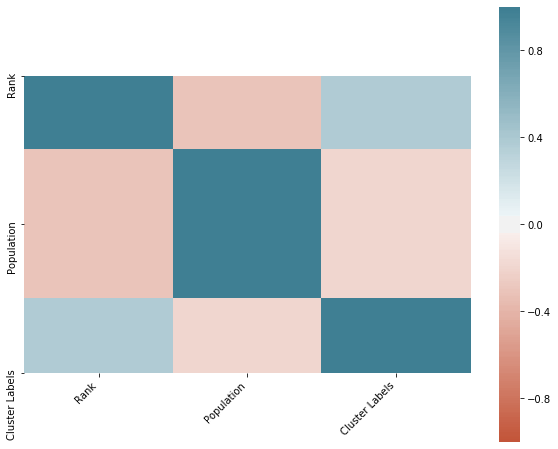

In [236]:
plt.figure(figsize = (10,8))
corr = final_table.drop(["Latitude","Longitude"],axis = 1).corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

plt.show()